## Оценка недвижимости

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from models.numpy.neural_network import NeuralNetwork
from utils.metrics import mse

### Подготовка данных

In [17]:
features_train = [] 
prices = []         

with open('../../data/property_price/preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    featuresTitles = { key: [] for key in reader.fieldnames if key != 'SalePrice' }
    salePrices = []
    
    for row in reader:
        try:
            salePrice = float(row['SalePrice'])
            salePrices.append(salePrice)
            
            for feature in featuresTitles:
                featuresTitles[feature].append(float(row[feature]))
        except ValueError:
            continue

salePrices = np.array(salePrices)
featuresTitles = { key: np.array(values) for key, values in featuresTitles.items() }

correlations = {}
for feature, values in featuresTitles.items():
    valid_indices = ~np.isnan(values) 
    if np.any(valid_indices):
        correlation = np.corrcoef(values[valid_indices], salePrices[valid_indices])[0, 1]
        correlations[feature] = abs(correlation) 

best_feature = max(correlations, key=correlations.get)
print(f"Лучший признак: {best_feature} (корреляция: {correlations[best_feature]:.5f})")

with open('../../data/property_price/preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row[best_feature] == 'NA' or row['SalePrice'] == 'NA':
            continue
        
        best_feature_value = float(row[best_feature])
        sale_price = float(row['SalePrice'])
        
        features_train.append([best_feature_value])
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Лучший признак: OverallQual (корреляция: 0.81751)


### Поиск лучшей архитектуры

In [18]:
input_layer_size = X_train.shape[1]
learning_rates = [0.1, 0.01, 0.001, 0.0001]

architectures = {
    '1x32x1': [input_layer_size, 32, 1],
    '1x64x1': [input_layer_size, 64, 1],
    '1x64x32x1': [input_layer_size, 64, 32, 1],
    '1x64x64x1': [input_layer_size, 64, 64, 1]  
}

results = {}

for name, layer_sizes in architectures.items():
    for lr in learning_rates:
        print(f"\nTraining: {name} | learning rate: {lr}")
        model = NeuralNetwork(layer_sizes, activation='relu', task='regression')
        losses = model.train(X_train_scaled, y_train, epochs=500, batch_size=32, learning_rate=lr)
        y_pred = model.predict(X_test_scaled)
        loss = mse(y_test, y_pred)
        
        key = f"{name}_{lr}"
        results[key] = {
            'loss': loss,
            'losses': losses,
            'architecture': layer_sizes,
            'learning_rate': lr,
            'parameters': model.parameters 
        }
        print(f"Test MSE: {loss:.5f}")


Training: 1x32x1 | learning rate: 0.1
Epoch 100/500, Loss: 0.0483
Epoch 200/500, Loss: 0.0505
Epoch 300/500, Loss: 0.0730
Epoch 400/500, Loss: 0.0470
Epoch 500/500, Loss: 0.0437
Test MSE: 0.04715

Training: 1x32x1 | learning rate: 0.01
Epoch 100/500, Loss: 0.0427
Epoch 200/500, Loss: 0.0418
Epoch 300/500, Loss: 0.0418
Epoch 400/500, Loss: 0.0418
Epoch 500/500, Loss: 0.0418
Test MSE: 0.04559

Training: 1x32x1 | learning rate: 0.001
Epoch 100/500, Loss: 0.0541
Epoch 200/500, Loss: 0.0463
Epoch 300/500, Loss: 0.0445
Epoch 400/500, Loss: 0.0437
Epoch 500/500, Loss: 0.0432
Test MSE: 0.04613

Training: 1x32x1 | learning rate: 0.0001
Epoch 100/500, Loss: 2.9058
Epoch 200/500, Loss: 0.2656
Epoch 300/500, Loss: 0.1879
Epoch 400/500, Loss: 0.1459
Epoch 500/500, Loss: 0.1203
Test MSE: 0.12997

Training: 1x64x1 | learning rate: 0.1
Epoch 100/500, Loss: 0.0444
Epoch 200/500, Loss: 0.0559
Epoch 300/500, Loss: 0.0424
Epoch 400/500, Loss: 0.0416
Epoch 500/500, Loss: 0.0507
Test MSE: 0.05527

Training

### Вывод результатов

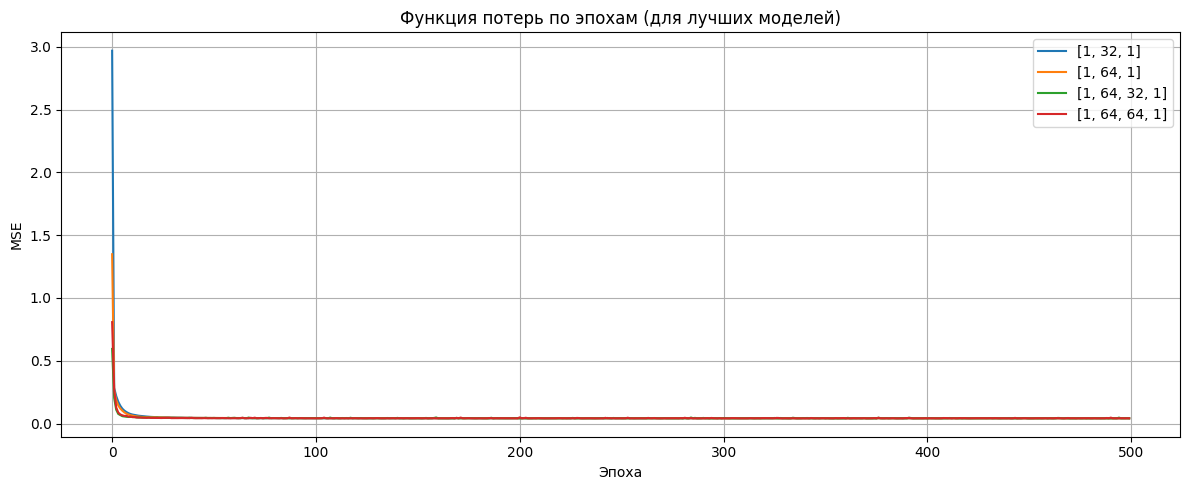

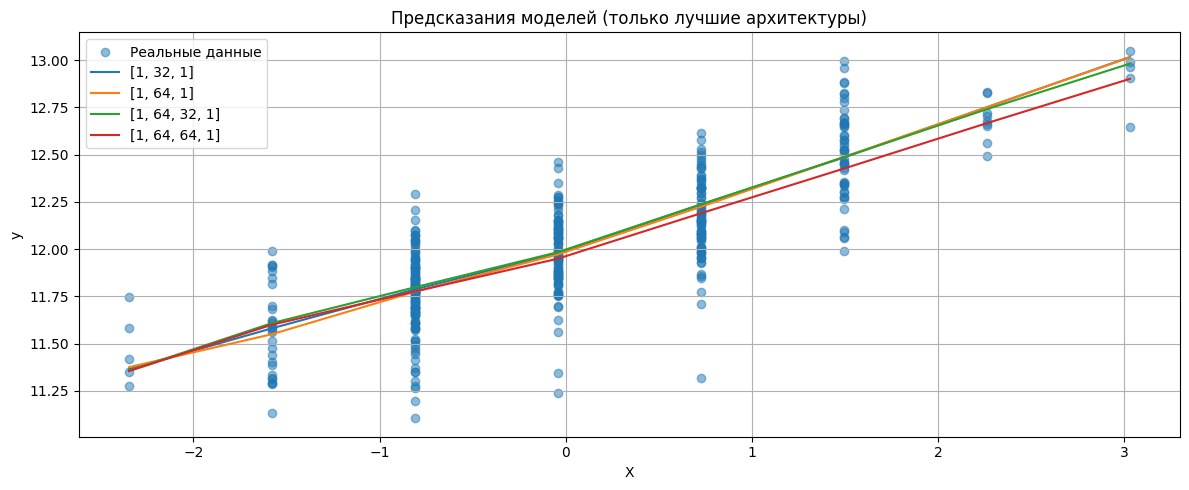

In [19]:
best_by_arch = {}

for key, val in results.items():
    arch = str(val['architecture']) 
    current_loss = val['loss']
    
    if arch not in best_by_arch or current_loss < best_by_arch[arch]['loss']:
        best_by_arch[arch] = val

plt.figure(figsize=(12, 5))
for arch_str, res in best_by_arch.items():
    plt.plot(res['losses'], label=arch_str)

plt.title("Функция потерь по эпохам (для лучших моделей)")
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sorted_idx = np.argsort(X_test_scaled[:, 0])
X_test_sorted = X_test_scaled[sorted_idx]
y_test_sorted = y_test[sorted_idx]

plt.figure(figsize=(12, 5))
plt.scatter(X_test_sorted, y_test_sorted, alpha=0.5, label="Реальные данные")

for arch_str, res in best_by_arch.items():
    temp_model = NeuralNetwork(res['architecture'], activation='relu', task='regression')
    temp_model.parameters = res['parameters']
    
    y_pred = temp_model.predict(X_test_scaled)[sorted_idx]
    plt.plot(X_test_sorted, y_pred, label=f"{arch_str}")

plt.title("Предсказания моделей (только лучшие архитектуры)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Обучение и предсказание

In [20]:
best_model_name = min(results, key=lambda k: results[k]['loss'])

best_architecture = results[best_model_name]['architecture']
best_learning_rate = results[best_model_name]['learning_rate']
print(f"Best architecture: {best_architecture}, learning rate: {best_learning_rate}") 

model = NeuralNetwork(best_architecture, 
                      activation='relu',
                      task='regression')
loses = model.train(X_train_scaled, y_train, 
                    epochs=500, 
                    batch_size=32, 
                    learning_rate=best_learning_rate)

y_pred = model.predict(X_test_scaled)

Best architecture: [1, 64, 1], learning rate: 0.01
Epoch 100/500, Loss: 0.0425
Epoch 200/500, Loss: 0.0422
Epoch 300/500, Loss: 0.0423
Epoch 400/500, Loss: 0.0420
Epoch 500/500, Loss: 0.0417


### Визуализация

Test MSE: 0.0456


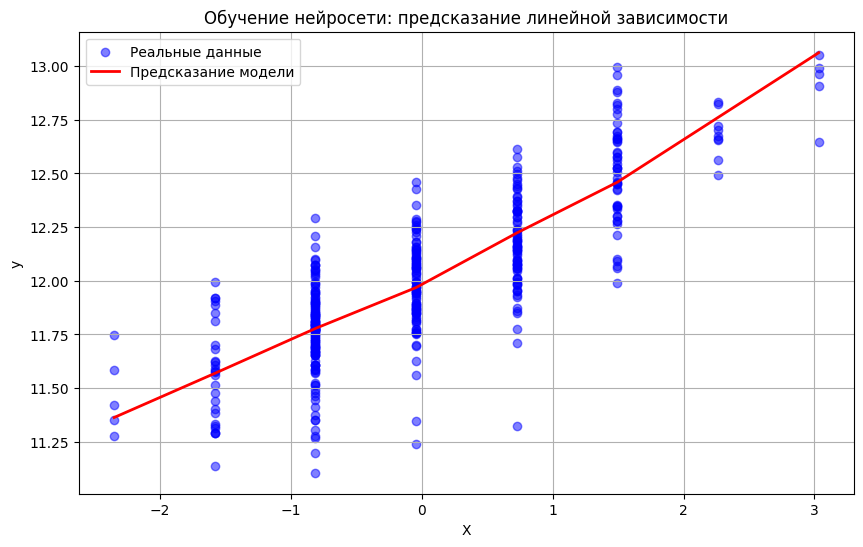

In [21]:
test_loss = mse(y_test, y_pred)
print(f"Test MSE: {test_loss:.4f}")

sorted_indices = np.argsort(X_test_scaled[:, 0])

plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[sorted_indices], y_test[sorted_indices], color='blue', alpha=0.5, label='Реальные данные')
plt.plot(X_test_scaled[sorted_indices], y_pred[sorted_indices], color='red', linewidth=2, label='Предсказание модели')
plt.title('Обучение нейросети: предсказание линейной зависимости')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Сравнение с другими моделями

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (degree=2)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Polynomial Regression (degree=3)": make_pipeline(PolynomialFeatures(3), LinearRegression()),
    "KNN (k=5)": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
}

model_results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train.ravel())
    y_pred = model.predict(X_test_scaled)
    loss = mean_squared_error(y_test.ravel(), y_pred)
    
    model_results[name] = {
        'loss': loss,
        'predictions': y_pred
    }

model_results["Neural Network"] = {
    'loss': results[best_model_name]['loss'],
    'predictions': y_pred.flatten()
}

### Вывод результатов в виде таблицы

In [23]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Test MSE': [res['loss'] for res in model_results.values()]
})

comparison_df.sort_values(by='Test MSE', ascending=True, inplace=True)

print("Таблица ошибок (MSE):")
print(comparison_df.to_string(index=False))

Таблица ошибок (MSE):
                           Model  Test MSE
Polynomial Regression (degree=2)  0.044989
Polynomial Regression (degree=3)  0.045065
                  Neural Network  0.045177
                   Random Forest  0.045279
                   Decision Tree  0.045316
               Linear Regression  0.045496
                       KNN (k=5)  0.055531


### Визуализация результатов

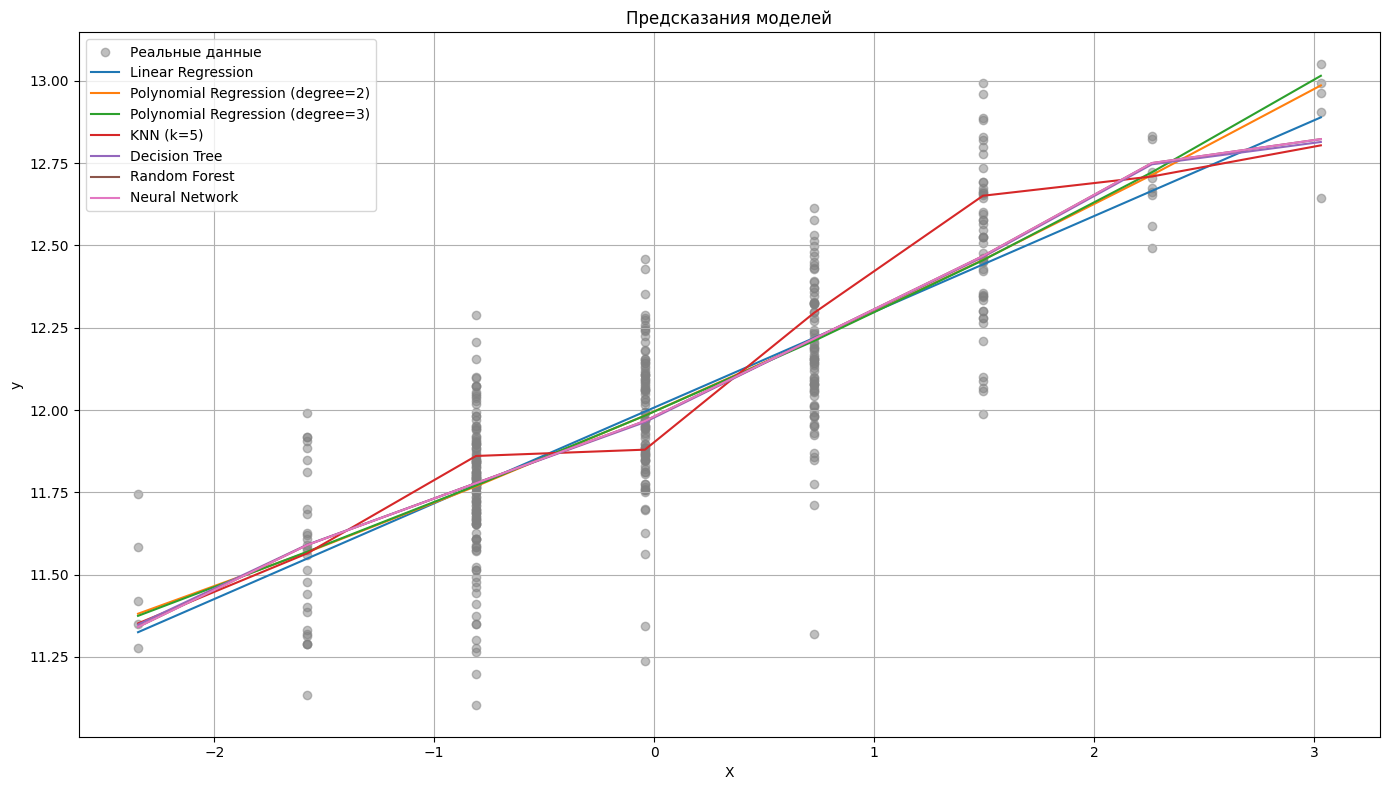

In [24]:
sorted_idx = np.argsort(X_test_scaled[:, 0])

plt.figure(figsize=(14, 8))
plt.scatter(X_test_scaled[sorted_idx], y_test[sorted_idx], alpha=0.5, label="Реальные данные", color='gray')

for name, res in model_results.items():
    plt.plot(X_test_scaled[sorted_idx], res['predictions'][sorted_idx], label=name)

plt.title("Предсказания моделей")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()